In [2]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.DBLP import DBLP
import dgl.function as fn
import torch
import numpy as np
import torch_geometric
torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /storage/scratch/0994359/hetero-conv-matching/.venv2/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /storage/scratch/0994359/hetero-conv-matching/.venv2/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:

dataset = DBLP() 
original_graph = dataset.load_graph(n_components=30)



In [4]:
device= "cuda:3"
original_graph = original_graph.to(device)
num_nearest_init_neighbors_per_type = {"papertoauthor": 50, "authortopaper": 50, "conferencetopaper":50, "papertoconference":50,"papertoterm":50, "termtopaper":50, "author":50 , "paper":50, "conference": 50, "term":50}
from Projections.CCA import CCA
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, use_zscore=False,device=device, cca_cls=CCA, pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=False, use_out_degree=False, checkpoints=[0.99]) 

coarsener.init()


/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


authortopaper
conferencetopaper
papertoauthor
papertoconference
papertoterm
termtopaper


In [5]:

coarsener.summarize()
coarsend_graph = coarsener.summarized_graph

#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("author")
coarsener.make_mask(mapping, "author")

labels = coarsener.get_labels(mapping, "author")
coarsend_graph.nodes["author"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=coarsend_graph.device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


step: 0, ratio: 1.0


/storage/scratch/0994359/hetero-conv-matching/Coarsener/HeteroCoarsener.py:395: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:39.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)


step: 1, ratio: 0.9995407225964482
step: 2, ratio: 0.9991197183098591
step: 3, ratio: 0.99869871402327
step: 4, ratio: 0.998277709736681
step: 5, ratio: 0.9978567054500919
step: 6, ratio: 0.9974357011635028
step: 7, ratio: 0.9970146968769137
step: 8, ratio: 0.9965936925903246
step: 9, ratio: 0.9961726883037355
step: 10, ratio: 0.9957516840171463
step: 11, ratio: 0.9953306797305572
step: 12, ratio: 0.9949096754439681
step: 13, ratio: 0.994488671157379
step: 14, ratio: 0.99406766687079
step: 15, ratio: 0.9936466625842009
step: 16, ratio: 0.9932256582976118
step: 17, ratio: 0.9928046540110227
step: 18, ratio: 0.9923836497244336
step: 19, ratio: 0.9919626454378444
step: 20, ratio: 0.9915416411512553
step: 21, ratio: 0.9911206368646662
step: 22, ratio: 0.9907761788120024
step: 23, ratio: 0.9904317207593386
step: 24, ratio: 0.9900872627066748
ratio 0.9899724433557869


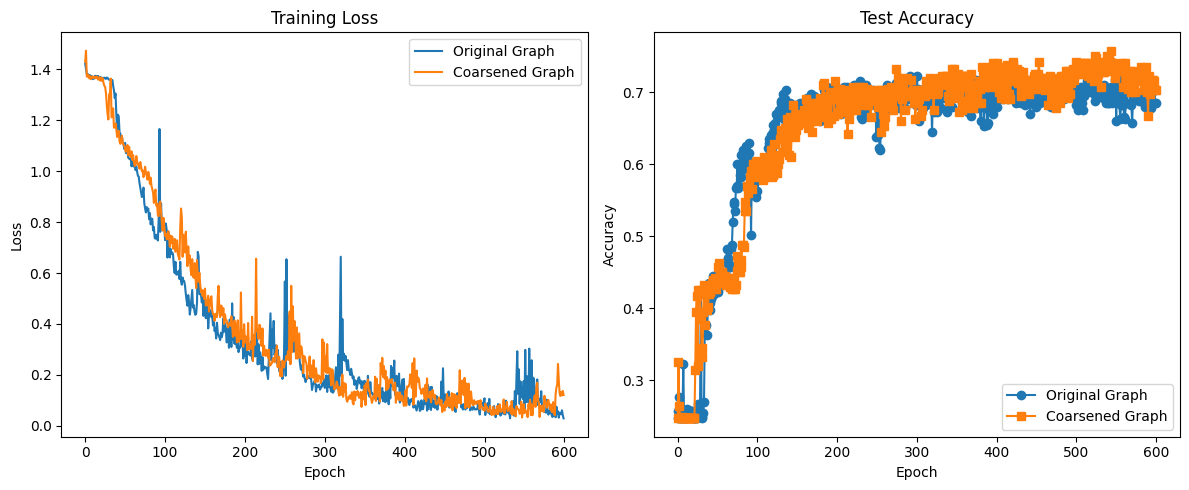

Final Performance Comparison:
Original Graph Accuracy: 0.6850
Coarsened Graph Accuracy: 0.7025

Original Graph Accuracy:
  Mean: 0.6850
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.7025
  Std:  0.0000


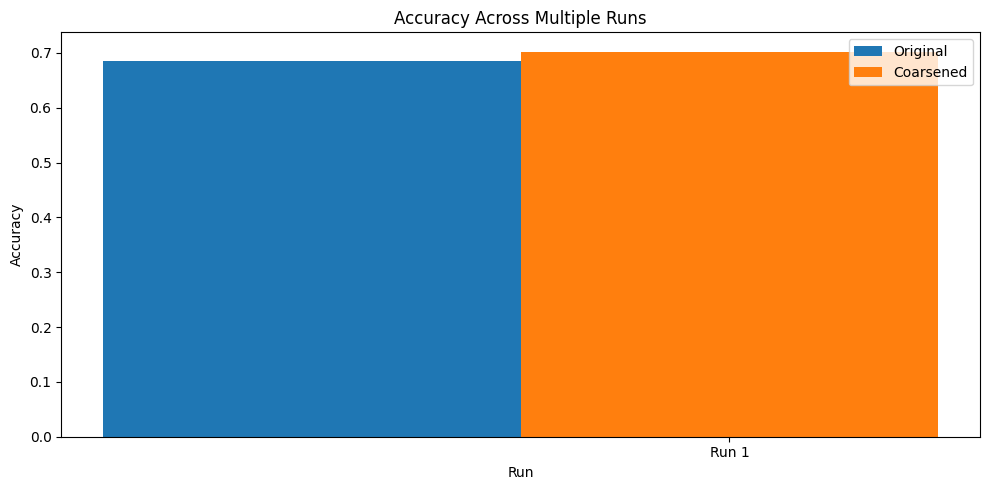

In [6]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN

from Experiments.model_helper import run_experiments

orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,  ImprovedGCN, num_runs=1, epochs=600,eval_interval=1, target_node_type="author")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(600))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)